<a href="https://colab.research.google.com/github/valdas-v1/Fatal-Police-Shooting-in-United-States/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fatal Police Shooting in United States

This project will take a look at killings that took place at the hands of police officers in the United States from the beginning of 2015 to into February 2017. The main goal is to explore the data, provide a list of issues and propose a plan on how to tackle these issues.

Details about the dataset can be found [here](https://www.kaggle.com/washingtonpost/police-shootings)

# Table of Contents
1. [Mental ilness among fatal police shootings](#mental_illness)
2. [Fatal shootings by state](#fatal_shootings)
3. [Hypothesis testing](#hypothesis_testing)
4. [Racial bias among fatal police shootings](#racial_bias)
5. [Cluster analysis](#cluster_analysis)
6. [Building a machine learning model](#machine_learning)

## Imports and dataset cleaning

### Imports

In [ ]:
# Data wrangling
import pandas as pd
import numpy as np

# Statistics
import scipy.stats as st

# Visualisations
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
# Importing the dataset
df = pd.read_csv('https://raw.githubusercontent.com/valdas-v1/Fatal-Police-Shooting-in-United-States/master/data/data.csv')

### Initial look at the dataset

In [ ]:
df.head(3)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False


The dataset provides data about each case, including the manner of death, whether there were signs of mental illness and so on

I will modify the 'race' column to make it more understandable

In [ ]:
df = df.replace({"race": {'W': 'White', 'B': 'Black', 'A': 'Asian', 'H': 'Hispanic', 'O': 'Other', 'N': 'Native'}})
df.head(1)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2142 non-null   int64  
 1   name                     2123 non-null   object 
 2   date                     2142 non-null   object 
 3   manner_of_death          2142 non-null   object 
 4   armed                    2136 non-null   object 
 5   age                      2099 non-null   float64
 6   gender                   2141 non-null   object 
 7   race                     2039 non-null   object 
 8   city                     2142 non-null   object 
 9   state                    2142 non-null   object 
 10  signs_of_mental_illness  2142 non-null   bool   
 11  threat_level             2142 non-null   object 
 12  flee                     2106 non-null   object 
 13  body_camera              2142 non-null   bool   
dtypes: bool(2), float64(1), 

Since 'Non-Null Counts' do not match, there are null values, the dataset will need to be cleaned

### Cleaning the dataset

In [ ]:
# Counting null values in each column
df.isnull().sum()

id                           0
name                        19
date                         0
manner_of_death              0
armed                        6
age                         43
gender                       1
race                       103
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        36
body_camera                  0
dtype: int64

In [ ]:
# Dropping all null values
clean_df = df.dropna().drop('id', axis=1).reset_index()

In [ ]:
# Parsing date column
clean_df['date'] = pd.to_datetime(clean_df['date'])

<a name="mental_illness"></a>
## Mental ilness among fatal police shootings 

Since we have the data, I would like to begin by exploring the data on mental ilness and shootings. I want to know where the mentally ill are shot most frequently

### Preprocessing data

I will create two DataFrames: one for counts of shootings, separated by whether there were signs of mental illness and another one, which will include only the cases with signs of mental illness

In [ ]:
# Grouping the data by state and if there are signs of mental ilness
mental_ilness = clean_df.groupby(['state','signs_of_mental_illness'], as_index = False).index.count()
mental_ilness.sort_values(by = ['signs_of_mental_illness', 'index'], ascending=[False, False], inplace = True)
mental_ilness = mental_ilness.rename(columns={"index": "count"})

In [ ]:
mental_ilness.head(2)

,state,signs_of_mental_illness,count
9,CA,True,76
84,TX,True,45


In [ ]:
# Filter cases where signs of mental ilness were present
mental_ilness_true = mental_ilness[mental_ilness['signs_of_mental_illness'] == True].drop('signs_of_mental_illness',                                                         axis=1).reset_index(drop=True)
mental_ilness_true.head(3)

,state,count
0,CA,76
1,TX,45
2,FL,34


### Fatal shootings by state <a name="fatal_shootings"></a>

Let us begin by visualising counts of victims with signs of mental illness by state

In [ ]:
# Interactive map of the USA to visualise shootings where signs of mental illness were present
fig = px.choropleth(mental_ilness_true,
                    locations="state",
                    color="count",
                    hover_name="state",
                    locationmode = 'USA-states')
fig.update_layout(
    title_text = 'Fatal shootings of people with signs of mental illness',
    geo_scope='usa',
)
fig.show()

<div><img width="800px" height="auto" src="https://raw.githubusercontent.com/valdas-v1/Fatal-Police-Shooting-in-United-States/master/images/mental_ilness_by_state.png" /></div>

As we can see, cases of fatally shot people with signs of mental illness vary greatly state-by-state, but California, Texas and Florida stand out having the most cases. Although, this does not tell us the whole story, so let us look at numbers

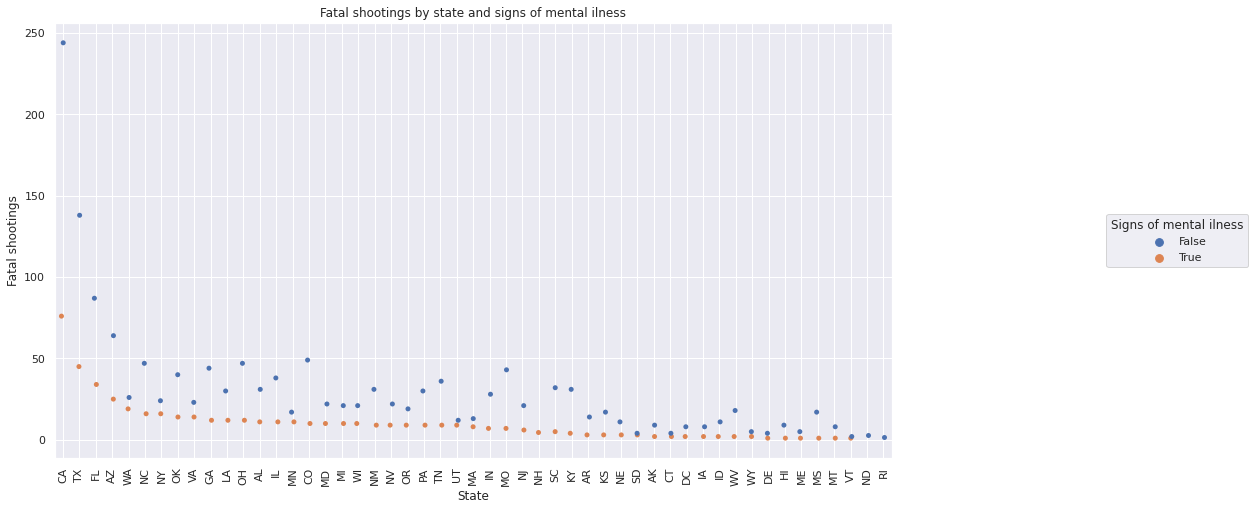

In [ ]:
# Plotting the data
fig, ax = plt.subplots(figsize = (15,8))
sns.stripplot(ax = ax,data = mental_ilness, x = 'state', y = 'count',
              hue = 'signs_of_mental_illness').legend(loc='center left', 
                                                      bbox_to_anchor=(1.25, 0.5), ncol=1, title='Signs of mental ilness')
plt.xticks(rotation=90)
ax.xaxis.grid(True)
plt.ylabel('Fatal shootings')
plt.xlabel('State')
plt.title('Fatal shootings by state and signs of mental ilness')        
plt.show()       

We can see that California has by far the most fatal shootings by the police, let us see if their average rate of shooting a mentally ill person is higher than the national average

<a name="hypothesis_testing"></a>
### Testing the hypothesis, that California's proportion of fatally shot people, with a mental illness is equal to the national proportion, with a 95% significance level: 

### H0: pC = pN


In [ ]:
# Calculating the proportion for every state
rate_of_shot_mental_ilness = mental_ilness.pivot('state','signs_of_mental_illness','count').apply(lambda x: x/x.sum(), axis = 1).sort_values(by = True).dropna()
rate_of_shot_mental_ilness.head(3)

signs_of_mental_illness,False,True
state,,
MS,0.944444,0.055556
WV,0.900000,0.100000
HI,0.900000,0.100000


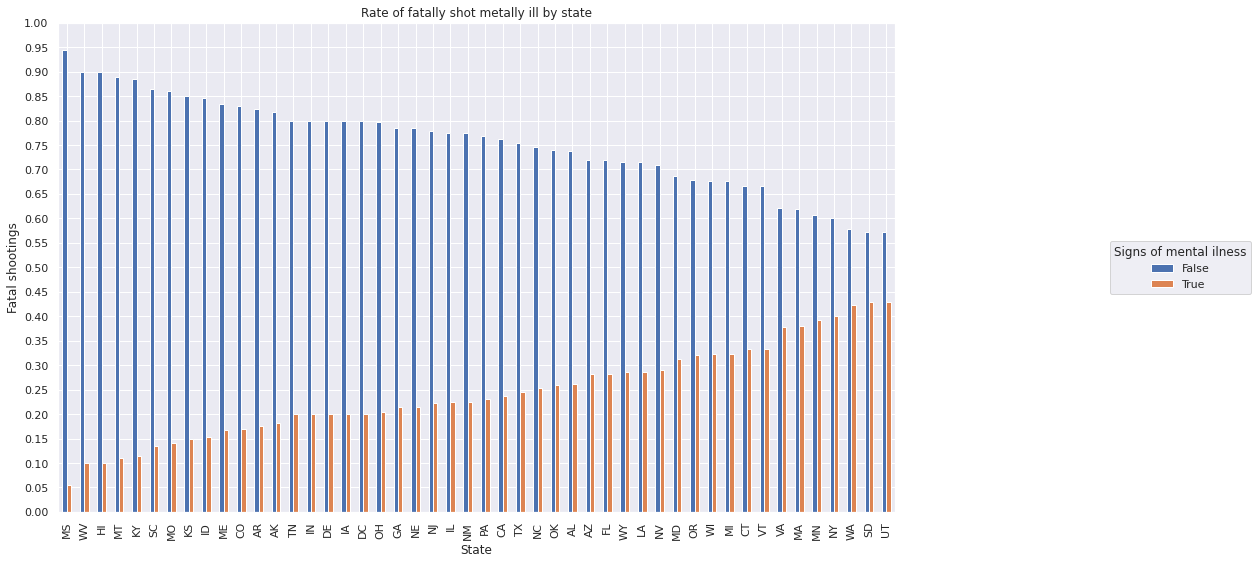

In [ ]:
# Plotting the proportion for every state

fig, ax = plt.subplots(figsize = (15,9))
rate_of_shot_mental_ilness.plot(kind='bar', ax=ax).legend(loc='center left', 
                                                      bbox_to_anchor=(1.25, 0.5), ncol=1, title='Signs of mental ilness')
plt.yticks(np.arange(0,1.05,0.05))
plt.ylabel('Fatal shootings')
plt.xlabel('State')
plt.title('Rate of fatally shot metally ill by state')
plt.show()  

From this graph, we can see on a state-by-state level, which states have the worst rates of fatally shooting people with mental illnesses. Worst performing states, such as Utah, San Diego and Washington should look into increasing officer training for dealing with mentally ill people or increase funding for free mental health services

Although California has a rate close to the middle, we can see that Utah has the highest rate, while Massachusetts has the lowest. Let us see if it is statistically significan using a z-test

### One-proportion z-test to test the null hypothesis

In [ ]:
# Defining variables for a One-proportion z-test
p_hat = rate_of_shot_mental_ilness[True].loc['CA']
p_0 = np.mean(rate_of_shot_mental_ilness[True])
n = np.sum(mental_ilness[mental_ilness['state'] == 'CA']['count'])

In [ ]:
# Calculating One-proportion z-test
z = (p_hat*p_0) / np.sqrt(p_0*(1 - p_0)) * np.sqrt(n)
z

2.4185893282110684

In [ ]:
# Calculating the p-value
p = 1 - st.norm.cdf(z)
p

0.0077904097297083474

We can reject the null hypothesis that the proportion of California and the national population proportion are equal (pC = pN), with a significance level of 95% as the p-value is 0.78%

<a name="racial_bias"></a>
## Racial bias among fatal police shootings

Next, let us explore the correlation between race and fatal police shootings

### Racial distribution of fatal police shootings

I will begin by plotting the counts of fatal shootings by race

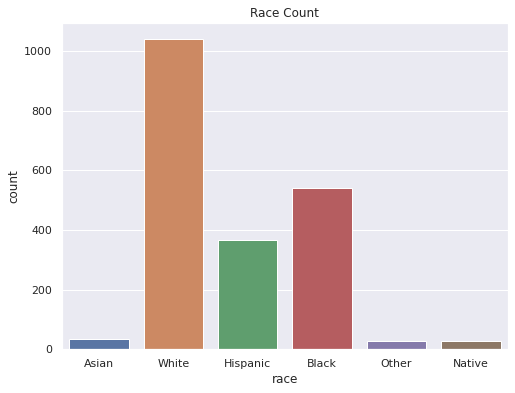

In [ ]:
# Plotting the race among fatal police shootings

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x=df['race'],ax=ax)
plt.title('Race Count')
plt.show()

Although it seems as if white people are shot most often, we need to keep in mind that >70% of the racial composition of the United States is white. Let us calculate the proportion of fatally shot unarmed people by race

Source for the [racial composition of the United States](https://en.wikipedia.org/wiki/Race_and_ethnicity_in_the_United_States)

### Percentage of unarmed people shot by race

To visualise this, I will first modify the 'armed' column of the data to be either 'True' or 'False' instead of all the different kinds of weapons available, then group by race and whether they were armed

In [ ]:
# Grouping the data by race and if they were armed
df_armed = clean_df
df_armed['armed'] = clean_df['armed'] != 'unarmed'

race_armed = df_armed.groupby(['race','armed'], as_index = False).index.count()
race_armed.sort_values(by = ['armed', 'index'], ascending=[False, False], inplace = True)
race_armed = race_armed.rename(columns={"index": "count"})
race_armed.head(3)

,race,armed,count
10,White,True,962
2,Black,True,467
4,Hispanic,True,326


Since the racial composition of the United States is not equal, we will once again need to work with proportions

In [ ]:
# Calculating the proportion of armed and unarmed police shootings
rate_race_armed = race_armed.pivot('race', 'armed', 'count').apply(lambda x: x/x.sum(), axis = 1).sort_values(by = True).dropna()
rate_race_armed.head(3)

armed,False,True
race,,
Other,0.142857,0.857143
Black,0.107075,0.892925
Hispanic,0.081690,0.918310


We can already see, that the biggest proportion of armed victims are white, but let us plot the results, to have a better understanding of the scale

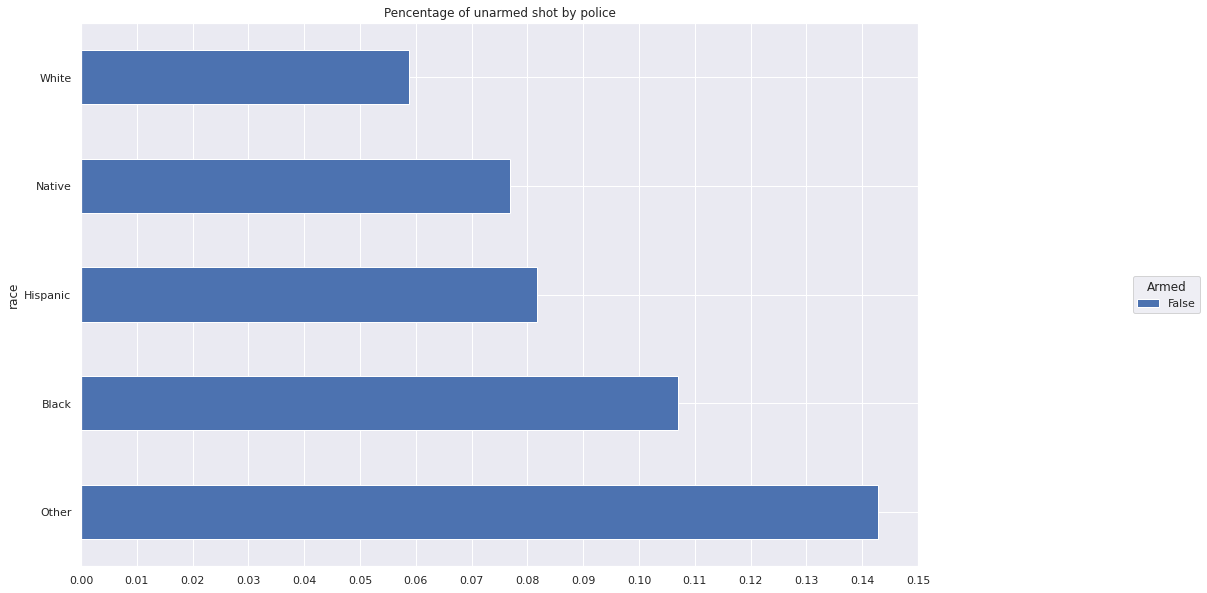

In [ ]:
# Plotting the results
fig, ax = plt.subplots(figsize = (15,10))
rate_race_armed[False].plot(kind = 'barh', stacked = True,ax = ax).legend(loc='center left', 
                                                      bbox_to_anchor=(1.25, 0.5), ncol=1, title='Armed')

plt.xticks(np.arange(0,np.max(rate_race_armed[False])+0.01,0.01))
plt.title('Pencentage of unarmed shot by police')
plt.show()

After analysing this graph, we can see that only about 6% of white people were shot unarmed, white the rate for black people is almost double at about 11%

Judging by the results, there is a clear racial problem in the police force of the United States. Individual states should look into more training and raising awareness of this problem

## Dimensionality reduction

Next, let us examine the data with dimensionality reduction and see whether the analysis forms distinct clusters of data

### Preprocessing data for PCA and t-SNE

Looking at the data to see if we can do dimensionality reduction

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    1986 non-null   int64         
 1   name                     1986 non-null   object        
 2   date                     1986 non-null   datetime64[ns]
 3   manner_of_death          1986 non-null   object        
 4   armed                    1986 non-null   bool          
 5   age                      1986 non-null   float64       
 6   gender                   1986 non-null   object        
 7   race                     1986 non-null   object        
 8   city                     1986 non-null   object        
 9   state                    1986 non-null   object        
 10  signs_of_mental_illness  1986 non-null   bool          
 11  threat_level             1986 non-null   object        
 12  flee                     1986 non-

As we can see, most of the data is non-numerical, so we will need to encode the data

In [ ]:
# Encoding text and bool values to integers as you can only perform dimensionality reduction on numerical values
encoded_df = pd.get_dummies(clean_df.filter(['manner_of_death',
                            'signs_of_mental_illness', 'armed', 'race'
                            ]))

encoded_df.head(3)

,signs_of_mental_illness,armed,manner_of_death_shot,manner_of_death_shot and Tasered,race_Asian,race_Black,race_Hispanic,race_Native,race_Other,race_White
0,True,True,1,0,1,0,0,0,0,0
1,False,True,1,0,0,0,0,0,0,1
2,False,False,0,1,0,0,1,0,0,0


### Principal component analysis

In [ ]:
# Calculating the maximum number of principal components
max_principal_components = min(len(encoded_df.columns), len(encoded_df))
print(f"The maximum number of principal components: {min(len(encoded_df.columns), len(encoded_df))}")

The maximum number of principal components: 10


In [ ]:
# Performing random PCA on encoded data, to find the optimal number of principal components
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(max_principal_components)
pca.fit(encoded_df)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

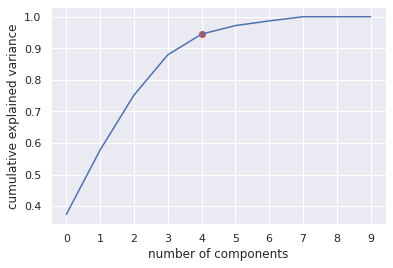

In [ ]:
# Plotting the cumulative explained variance by the number of components to find the 'elbow'
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.xticks(range(10))
plt.scatter(4, np.cumsum(pca.explained_variance_ratio_)[4], color='r')
plt.show()

Judging by the graph, I believe the optimal number of principal components is 4

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(encoded_df)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# Calculating variance explained by 4 principal components
print(f"The 4 components account for {round(np.sum(pca.explained_variance_ratio_), 1)*100}% variance")

The 4 components account for 90.0% variance


In [ ]:
# repeating PCA with only 2 components to be able to plot it
pca = PCA(n_components=2)
pca.fit(encoded_df)
x_pca = pca.fit_transform(encoded_df)

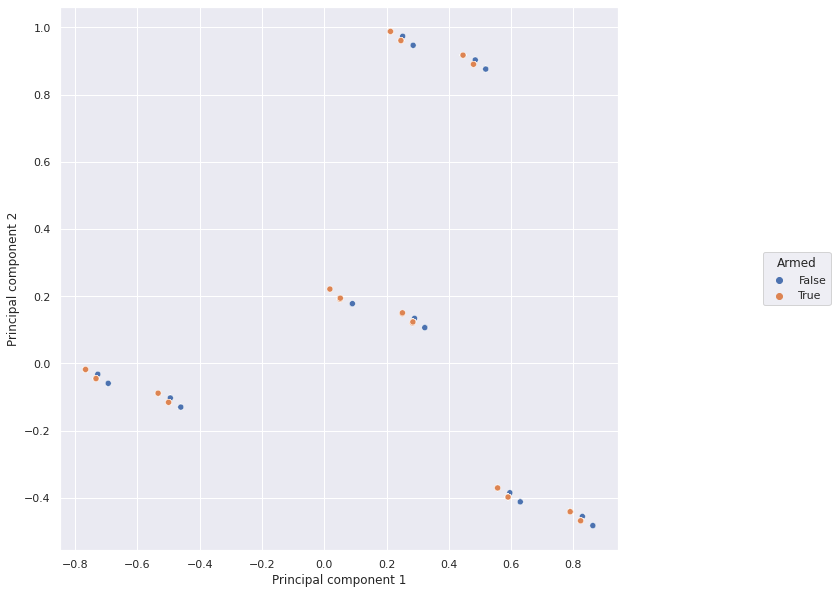

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 10))
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2');
sns.scatterplot(x = x_pca[:, 0], y = x_pca[:, 1], hue=clean_df.armed).legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, title='Armed')

As we can see, principal component analysis forms four distinct clusters of data

### t-SNE

In [ ]:
# Performing t-SNE on the same encoded values and visualising the result

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(encoded_df)

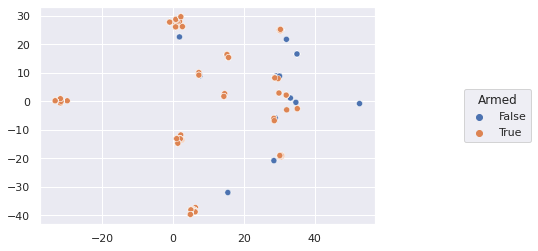

In [ ]:
sns.scatterplot(x = tsne[:, 0], y = tsne[:, 1], hue=clean_df.armed).legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, title='Armed')

<a name="cluster_analysis"></a>
## Cluster analysis

Performing cluster analysis on the data to group and analyse similar shootings

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    1986 non-null   int64         
 1   name                     1986 non-null   object        
 2   date                     1986 non-null   datetime64[ns]
 3   manner_of_death          1986 non-null   object        
 4   armed                    1986 non-null   bool          
 5   age                      1986 non-null   float64       
 6   gender                   1986 non-null   object        
 7   race                     1986 non-null   object        
 8   city                     1986 non-null   object        
 9   state                    1986 non-null   object        
 10  signs_of_mental_illness  1986 non-null   bool          
 11  threat_level             1986 non-null   object        
 12  flee                     1986 non-

In [ ]:
# Encoding string data to numeric for clustering
X = pd.get_dummies(clean_df.filter(['manner_of_death', 'signs_of_mental_illness', 'armed', 'race', 'flee', 'gender']))

Since we're doing KMeans clustering, we need to determine the optimal k

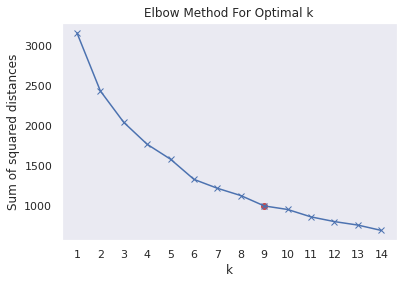

In [ ]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)


# Plotting the sum of square distances by k to find optimal k
plt.grid()
plt.xticks(range(15))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.scatter(9, Sum_of_squared_distances[8], color='r')
plt.show()

Judging by the graph, the optimal k is either at 4 or 9, but I would like to have more separation between clusters, so I will perform k-means clustering with the k of 9

In [ ]:
# Performing k-means clustering with the optimal k of 9
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9, random_state=42)
clusters = kmeans.fit_predict(X)
clusters

array([4, 1, 0, ..., 1, 2, 7], dtype=int32)

Now that we have the clusters of similar shootings, let us convert the case id's to  something more understandable

In [ ]:
# Making the clusters understandable by converting cluster id to the index in the original dataframe
similar_shootings = []

for num in range(np.max(clusters)+1):
  similar_shootings.append(np.squeeze(np.where(clusters == num)))

similar_shootings[0][:10]

array([  2,  10,  23,  38,  43,  51,  68,  74,  99, 111])

Next, I will count the unique values of each cluster to see how similar are the samples in each cluster

In [ ]:
# Iterating through each cluster, counting unique values for every column and adding them to a list (DataFrame)
clusters_unique_counts = pd.DataFrame()

for cluster in similar_shootings:
  current_cluster = pd.DataFrame()
  for id in cluster:
    current_cluster[id] = clean_df.iloc[id].drop(['index', 'date', 'name'])

  clusters_unique_counts = clusters_unique_counts.append(current_cluster.T.describe().T['unique'].to_frame().T)

clusters_unique_counts

,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
unique,1,2,46,2,5,110,33,2,3,4,2
unique,1,2,60,2,4,421,48,1,3,2,2
unique,1,2,52,2,1,213,39,2,3,2,2
unique,1,2,50,2,2,216,30,2,3,4,2
unique,1,2,55,2,4,254,46,1,3,2,2
unique,2,2,46,2,4,148,38,2,3,1,2
unique,2,2,32,2,1,75,28,2,3,1,2
unique,2,2,33,2,4,80,31,2,3,1,2
unique,2,2,37,1,1,84,33,2,3,1,2


The resulting DataFrame has a row for each cluster and each row has a count for every unique value in each column. This helps us see how the samples are similar. For example, if a row has a column with a unique count of 1, the samples in that cluster all share the same value for that column

For instance, let us examine the second cluster. From the unique value counts we know, that samples in this cluster have the same matter of death and mental state. 

Let us explore what those values are

In [ ]:
current_cluster = pd.DataFrame()
for id in similar_shootings[1]:
  current_cluster[id] = clean_df.iloc[id].drop(['index', 'date', 'name'])

current_cluster.T.head(3)

,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
1,shot,True,47,M,White,Aloha,OR,False,attack,Not fleeing,False
5,shot,True,18,M,White,Guthrie,OK,False,attack,Not fleeing,False
7,shot,True,35,M,White,Assaria,KS,False,attack,Not fleeing,False


We can see that the samples in the second cluster were all shot and did not have signs of mental illness

<a name="machine_learning"></a>
## Building a machine learning model to predict the race of the victim

Next, I would like to see whether we can build a model to predict the race of the victim based on provided details about their death

Let us set a base-line for model accuracy to know if it's any better than just random guessing. For this, I will calculate the proportion of each race to see if our model is better than just guessing the most common race

In [ ]:
clean_df['race'].value_counts(normalize=True)

White       0.514602
Black       0.263343
Hispanic    0.178751
Asian       0.016113
Other       0.014099
Native      0.013092
Name: race, dtype: float64

We can see that the most common race is W (white) and its proportion is at 51.5%, so our model should have a better accuracy than 51.5%

Once again, we need to begin by encoding our categorical values

In [ ]:
# Separating and encoding data to integers
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(clean_df['race'])
X = pd.get_dummies(clean_df.filter(['manner_of_death', 'signs_of_mental_illness',
                                    'armed', 'flee', 'threat_level', 'state', 'gender', 
                                    'age', 'city']))

I will also split the dataset into training and testing sets to be able to test the final model accuracy on previously unseen data

In [ ]:
# Splitting the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=42)

Next, I will train a RandomForestClassifier on the training data and test its accuracy on the unseen testing data

In [ ]:
# Building a random forests classifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

print(f"Model predicts with {round((rfc.score(X_test, y_test)*100), 2)}% accuracy")

Model predicts with 61.56% accuracy


We can see that the model predicts >60% accuracy. That is a bit better than just guessing